In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# metric functions
# MAE
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [3]:
# get the data
Addr_Inp = '/data/workspace_files/ten_feature_set.csv'

df_features = pd.read_csv(Addr_Inp)
df_features['Date'] = pd.to_datetime(df_features.Date.values)
df_features = df_features.set_index('Date')
print('Data loaded.')

Data loaded.


In [4]:
# build target data and look-back data
N_target = 7
Y_total = np.zeros((df_features.shape[0], N_target), dtype=np.float)
for i in range(N_target):
    Y_total[:-(i + 1), i] = df_features['Weighted Volume Price'].values[(i + 1):] / df_features[
        'Weighted Volume Price'].values[:-(i + 1)] - 1
print('Target data generated.')

N_lookback = 48
X_lookback = np.zeros((df_features.shape[0], N_lookback), dtype=np.float)
X_lookback[:, 0] = df_features['Weighted Volume Price'].values
for i in range(1, N_lookback):
    X_lookback[i:, i] = df_features['Weighted Volume Price'].values[:-i]
print('Lookback data generated.')

Target data generated.
Lookback data generated.


In [5]:
# truncate each dataset so that every value is meaningful
pos_beg = 199
df_features = df_features.iloc[pos_beg:-N_target, :]
df_features = df_features.iloc[:, 1:]
# normalize df_features so that training will be more stable
df_features.iloc[:, :] = (df_features.values - np.mean(df_features.values, axis=0)) / np.std(df_features.values, axis=0)
Y_total = Y_total[pos_beg:-N_target, :]
X_lookback = X_lookback[pos_beg:-N_target, :]
price_current = X_lookback[:, 0]
Y_total = pd.DataFrame(Y_total, index=df_features.index.values)
X_lookback = pd.DataFrame(X_lookback, index=df_features.index.values)

# normalize X_lookback
X_lookback_norm = (X_lookback.values - np.mean(X_lookback.values, axis=0)) / np.std(
    X_lookback.values, axis=0)
X_lookback_norm = pd.DataFrame(X_lookback_norm, index=df_features.index.values)
df_features_norm = (df_features.values - np.mean(df_features.values, axis=0)) / np.std(
    df_features.values, axis=0)
df_features_norm = pd.DataFrame(df_features_norm, index=df_features.index.values)

# divide these datasets into train, validation, and test
breakpoint_train_beg = pd.to_datetime('2014-07-23 00:00:00')
breakpoint_train_valid = pd.to_datetime('2019-02-01 00:00:00')
breakpoint_valid_test = pd.to_datetime('2019-08-01 00:00:00')
breakpoint_test_end = pd.to_datetime('2020-07-01 00:00:00')

price_current_train = price_current[(breakpoint_train_beg <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_train_valid)]
price_current_valid = price_current[(breakpoint_train_valid <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_valid_test)]
price_current_test = price_current[(breakpoint_valid_test <= Y_total.index.values) &
                        (Y_total.index.values < breakpoint_test_end)]

Y_train = Y_total.values[(breakpoint_train_beg <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_train_valid), :]
Y_valid = Y_total.values[(breakpoint_train_valid <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_valid_test), :]
Y_test = Y_total.values[(breakpoint_valid_test <= Y_total.index.values) &
                        (Y_total.index.values < breakpoint_test_end), :]

X_lookback_train_norm = X_lookback_norm.values[(breakpoint_train_beg <= Y_total.index.values) &
                                     (Y_total.index.values < breakpoint_train_valid), :]
X_lookback_valid_norm = X_lookback_norm.values[(breakpoint_train_valid <= X_lookback.index.values) &
                                     (X_lookback.index.values < breakpoint_valid_test), :]
X_lookback_test_norm = X_lookback_norm.values[(breakpoint_valid_test <= Y_total.index.values) &
                                    (Y_total.index.values < breakpoint_test_end), :]

X_features_train_norm = df_features_norm.values[(breakpoint_train_beg <= Y_total.index.values) &
                                      (Y_total.index.values < breakpoint_train_valid), :]
X_features_valid_norm = df_features_norm.values[(breakpoint_train_valid <= df_features.index.values) &
                                     (df_features.index.values < breakpoint_valid_test), :]
X_features_test_norm = df_features_norm.values[(breakpoint_valid_test <= Y_total.index.values) &
                                     (Y_total.index.values < breakpoint_test_end), :]

X_lookback_train = X_lookback.values[(breakpoint_train_beg <= Y_total.index.values) &
                                     (Y_total.index.values < breakpoint_train_valid), :]
X_lookback_valid = X_lookback.values[(breakpoint_train_valid <= X_lookback.index.values) &
                                     (X_lookback.index.values < breakpoint_valid_test), :]
X_lookback_test = X_lookback.values[(breakpoint_valid_test <= Y_total.index.values) &
                                    (Y_total.index.values < breakpoint_test_end), :]

In [6]:
# 1. build 2 simple benchmark predictions, and calculate MAE for the following on validation set
# a: Average
benchmark_valid_mean = np.mean(X_lookback_valid, axis=1)[:, np.newaxis]
MAE_benchmark_valid_mean = MAE((Y_valid + 1) * price_current_valid[:, np.newaxis], benchmark_valid_mean)
print('MAE for the average benchmark:', MAE_benchmark_valid_mean)

# b: Last value and using broadcasting to compare against the matrix of true values
benchmark_valid_last = X_lookback_valid[:, :1]
MAE_benchmark_valid_last = MAE((Y_valid + 1) * price_current_valid[:, np.newaxis], benchmark_valid_last)
print('MAE for the last benchmark:', MAE_benchmark_valid_last)

MAE for the average benchmark: 187.1302131647172
MAE for the last benchmark: 73.18754885432769


Epoch 1/100
78/78 [==============================] - 1s 5ms/step - loss: 0.2302 - val_loss: 0.0366
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.0260
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0212
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.0185
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0167
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0158
Epoch 8/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.0151
Epoch 9/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0146
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.0145
Epoch 11/

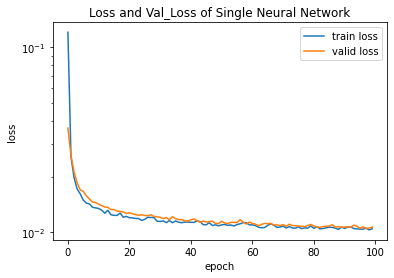

In [9]:
# 2. build and train a simple neural network by flattening the data and use 2 layers
    # calculate the train and validation loss for each epoch
X_train = np.column_stack([X_lookback_train_norm, X_features_train_norm])
X_valid = np.column_stack([X_lookback_valid_norm, X_features_valid_norm])
X_test = np.column_stack([X_lookback_test_norm, X_features_test_norm])

n_epochs, batch_size = 100, 512
LR = 0.0003
# use this selected data to train the neural network
mod_NN_Simple = tf.keras.Sequential([tf.keras.layers.Dense(64, input_shape=[X_train.shape[1]],
                                                           activation='relu',
                                                           kernel_initializer='he_uniform'),
                                     tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
                                     tf.keras.layers.Dense(N_target)])
mod_NN_Simple.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=LR))

fit_history = mod_NN_Simple.fit(X_train, Y_train, epochs=n_epochs,
                                batch_size=batch_size, verbose=1,
                                validation_data=(X_valid, Y_valid))

print('MAE for simple NN:', MAE(((Y_valid + 1) * price_current_valid[:, np.newaxis]),
                                (mod_NN_Simple.predict(X_valid) + 1) * price_current_valid[:, np.newaxis]))

# plot the train and validation loss for each epoch
plt.plot(fit_history.history['loss'], label='train loss')
plt.plot(fit_history.history['val_loss'], label='valid loss')
plt.title('Loss and Val_Loss of Single Neural Network')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
# Part 4: Evaluation
# 1: Evaluate each of the models in Part 3 on the test set, calculate MAE and RMSE

# two benchmarks
benchmark_test_mean = np.mean(X_lookback_test, axis=1)[:, np.newaxis]
benchmark_test_last = X_lookback_test[:, :1]

MAE_test_benchmark_mean = MAE((Y_test + 1) * price_current_test[:, np.newaxis], benchmark_test_mean)
MAE_test_benchmark_last = MAE((Y_test + 1) * price_current_test[:, np.newaxis], benchmark_test_last)

RMSE_test_benchmark_mean = RMSE((Y_test + 1) * price_current_test[:, np.newaxis], benchmark_test_mean)
RMSE_test_benchmark_last = RMSE((Y_test + 1) * price_current_test[:, np.newaxis], benchmark_test_last)

print('For the benchmark using the average values, MAE:', MAE_test_benchmark_mean, ', RMSE:', RMSE_test_benchmark_mean)
print('For the benchmark using the last values, MAE:', MAE_test_benchmark_last, ', RMSE:', RMSE_test_benchmark_last)

# Simple neural network
MAE_test_NN_Simple = MAE((Y_test + 1) * price_current_test[:, np.newaxis], 
                         (mod_NN_Simple.predict(X_test) + 1) * price_current_test[:, np.newaxis])
RMSE_test_NN_Simple = RMSE((Y_test + 1) * price_current_test[:, np.newaxis], 
                           (mod_NN_Simple.predict(X_test) + 1) * price_current_test[:, np.newaxis])
print('For the simple neural network, MAE:', MAE_test_NN_Simple, ', RMSE:', RMSE_test_NN_Simple)

For the benchmark using the average values, MAE: 184.66948171543055 , RMSE: 283.3332256123147
For the benchmark using the last values, MAE: 72.31551005172506 , RMSE: 125.83200675065106
For the simple neural network, MAE: 96.00571808548499 , RMSE: 147.10824811549276
